In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano
import theano.tensor as tt

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


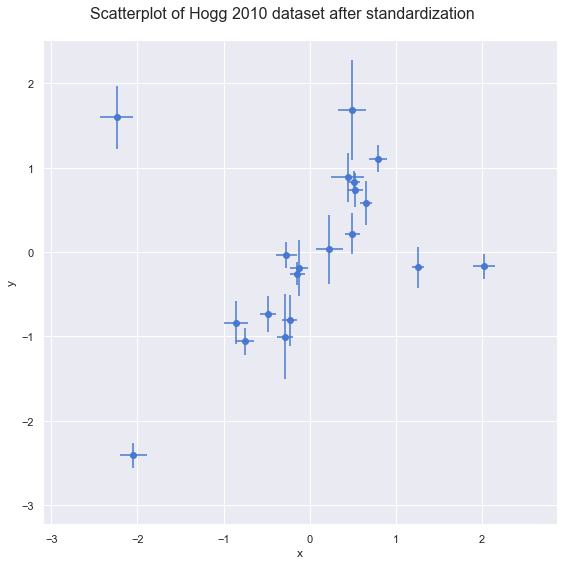

In [3]:
#### cut & pasted directly from the fetch_hogg2010test() function
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

## create xlims ylims for plotting
xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5
                 ,dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5
                 ,dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

## scatterplot the standardized data
g = sns.FacetGrid(dfhoggs, height=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)

In [4]:
with pm.Model() as mdl_ols:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sigma=1)
    b1 = pm.Normal('b1_slope', mu=0, sigma=1)

    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']

    ## Use y error from dataset, convert into theano variable
    sigma_y = theano.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=theano.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sigma=sigma_y, observed=dfhoggs['y'])

In [5]:
with mdl_ols:
    ## take samples
    traces_ols = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1_slope, b0_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


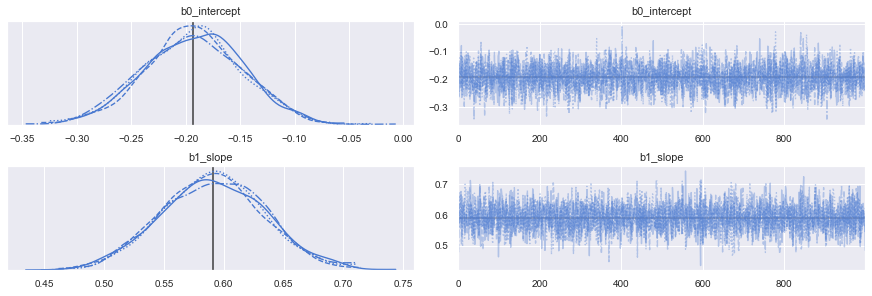

In [6]:
_ = pm.traceplot(traces_ols,
                 lines=tuple([(k, {}, v['mean'])
                              for k, v in pm.summary(traces_ols).iterrows()]))

In [7]:
with pm.Model() as mdl_studentt:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sigma=1)
    b1 = pm.Normal('b1_slope', mu=0, sigma=1)

    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']

    ## Use y error from dataset, convert into theano variable
    sigma_y = theano.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=theano.config.floatX), name='sigma_y')

    ## define prior for Student T degrees of freedom
    nu = pm.Uniform('nu', lower=1, upper=100)

    ## Define Student T likelihood
    likelihood = pm.StudentT('likelihood', mu=yest, sigma=sigma_y, nu=nu,
                             observed=dfhoggs['y'])


In [8]:
with mdl_studentt:
    ## take samples
    traces_studentt = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, b1_slope, b0_intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.7003246686769916, but should be close to 0.8. Try to increase the number of tuning steps.


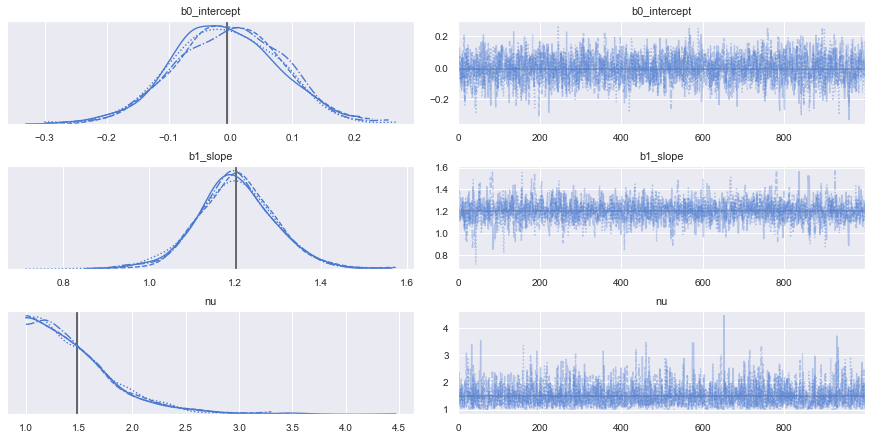

In [9]:
_ = pm.traceplot(traces_studentt,
                 lines=tuple([(k, {}, v['mean'])
                              for k, v in pm.summary(traces_studentt).iterrows()]))

In [55]:
with pm.Model() as mdl_signoise:

    ## Define informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sigma=1, testval=pm.floatX(0.1))
    b1 = pm.Normal('b1_slope', mu=0, sigma=1, testval=pm.floatX(1.))

    ## Define linear model
    yest_in = b0 + b1 * dfhoggs['x']

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sigma=10, testval=pm.floatX(1.))
    sigma_y_out = pm.HalfNormal('sigma_y_out', sigma=5, testval=pm.floatX(1.))

    ## Define Bernoulli inlier / outlier flags according to a hyperprior
    ## fraction of outliers, itself constrained to [0, .5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0],
                              testval=np.random.rand(dfhoggs.shape[0]) < 0.2)

    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = theano.shared(np.asarray(dfhoggs['y'], dtype=theano.config.floatX))
    sigma_y_in = np.asarray(dfhoggs['sigma_y'], dtype=theano.config.floatX)

    # Set up normal distributions that give us the logp for both distributions
    inliers = pm.Normal.dist(mu=yest_in, sigma=sigma_y_in).logp(yobs)
    outliers = pm.Normal.dist(mu=yest_out, sigma=sigma_y_in + sigma_y_out).logp(yobs)
    # Build custom likelihood, a potential will just be added to the logp and can thus function
    # like a likelihood that we would add with the observed kwarg.
    pm.Potential('obs', ((1 - is_outlier) * inliers).sum() + (is_outlier * outliers).sum())

In [65]:
sigma_y_in

array([0.59595518, 0.24424393, 0.37125077, 0.14654636, 0.2051649 ,
       0.14654636, 0.26378344, 0.1367766 , 0.29309271, 0.15631611,
       0.1367766 , 0.24424393, 0.50802737, 0.15631611, 0.33217174,
       0.30286247, 0.4103298 , 0.25401368, 0.15631611, 0.21493466])

In [56]:
with mdl_signoise:
    traces_signoise = pm.sample(tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, yest_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 30 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6737197229151795, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


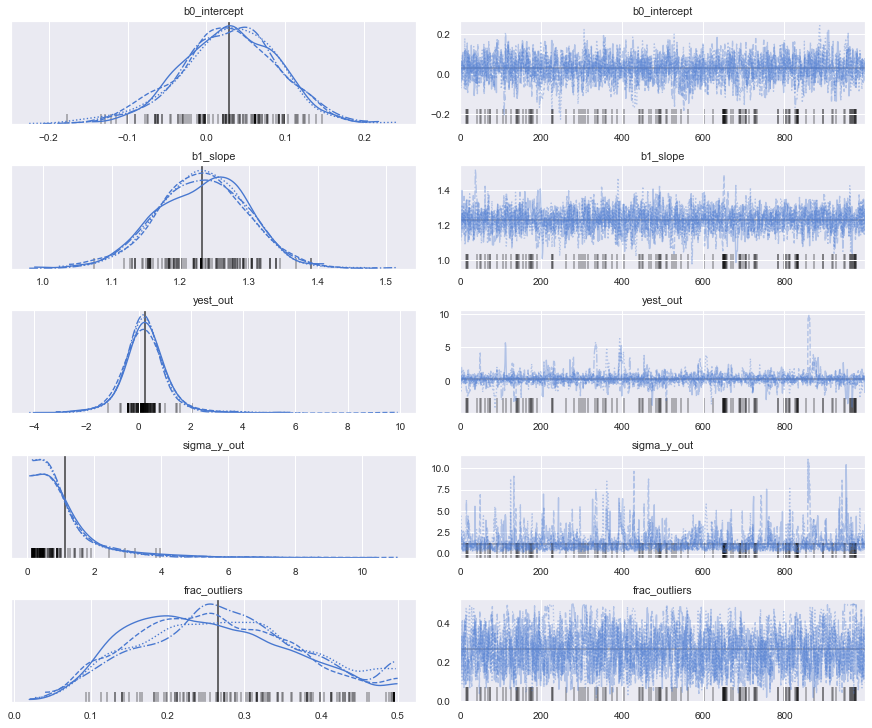

In [12]:
varnames = ['b0_intercept', 'b1_slope', 'yest_out', 'sigma_y_out', 'frac_outliers']
_ = pm.traceplot(traces_signoise, var_names=varnames,
                 lines=tuple([(k, {}, v['mean'])
                              for k, v in pm.summary(traces_signoise, varnames=varnames).iterrows()]))

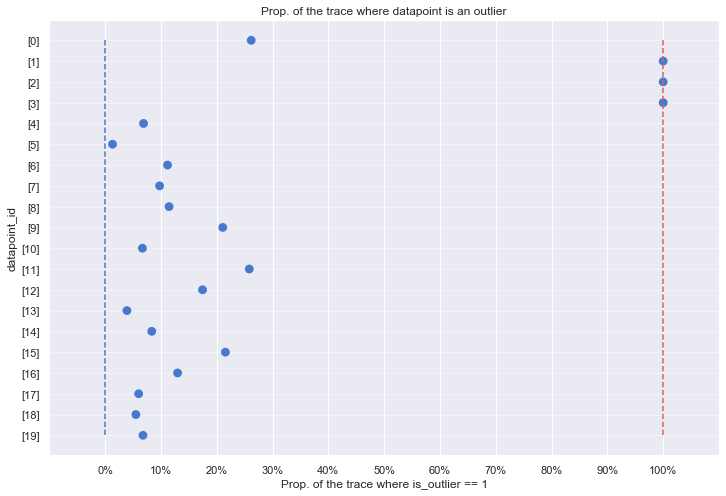

In [13]:
outlier_melt = pd.melt(pd.DataFrame(traces_signoise['is_outlier', -1000:],
                                   columns=['[{}]'.format(int(d)) for d in dfhoggs.index]),
                      var_name='datapoint_id', value_name='is_outlier')
ax0 = sns.pointplot(y='datapoint_id', x='is_outlier', data=outlier_melt,
                   kind='point', join=False, ci=None, size=4, aspect=2)

_ = ax0.vlines([0,1], 0, 19, ['b','r'], '--')

_ = ax0.set_xlim((-0.1,1.1))
_ = ax0.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax0.set_xticklabels(['{:.0%}'.format(t) for t in np.arange(0,1.1,0.1)])

_ = ax0.yaxis.grid(True, linestyle='-', which='major', color='w', alpha=0.4)
_ = ax0.set_title('Prop. of the trace where datapoint is an outlier')
_ = ax0.set_xlabel('Prop. of the trace where is_outlier == 1')

In [14]:
cutoff = 5
dfhoggs['outlier'] = np.percentile(traces_signoise['is_outlier'], cutoff, axis=0)
dfhoggs['outlier'].value_counts()

0.0    17
1.0     3
Name: outlier, dtype: int64

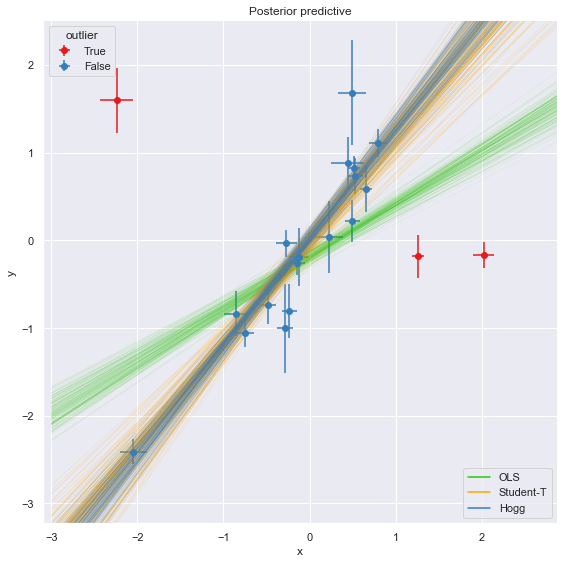

In [15]:
from matplotlib.lines import Line2D

g = sns.FacetGrid(dfhoggs, height=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0_intercept'] + samp['b1_slope'] * x

pm.plot_posterior_predictive_glm(traces_ols,
        eval=np.linspace(-3, 3, 10), lm=lm, samples=200, color='#22CC00', alpha=.2)

pm.plot_posterior_predictive_glm(traces_studentt, lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#FFA500', alpha=.5)

pm.plot_posterior_predictive_glm(traces_signoise, lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#357EC7', alpha=.3)

ols_line = Line2D([0], [0], color='#22CC00')
studentt_line = Line2D([0], [0], color='#FFA500')
hogg_line = Line2D([0], [0], color='#357EC7')
line_legend = plt.legend([ols_line, studentt_line, hogg_line], ['OLS', 'Student-T', 'Hogg'], loc=4)
plt.gca().add_artist(line_legend)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='').add_legend()
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

In [166]:
# Using Hogg to fit my data
point_muts = pd.read_csv('utils/point_muts.csv', index_col=0, header=[0,1])

# Create a DataFrame in the shape of the example dataframe
data = pd.DataFrame(np.array([
    point_muts.loc[:, ('Zero', 'score')].values,
    point_muts.loc[:, ('Radicicol', 'score')].values,
    point_muts.loc[:, ('Zero', 'SE')].values,
    point_muts.loc[:, ('Radicicol', 'SE')].values
]).T,
    index=point_muts.index.tolist(),
    columns=['x', 'y' ,'sigma_x', 'sigma_y'])

# Delete points with SE=0.0
data = data[2:]
data = data[~(data['sigma_x'] == 0.0)]
data = data[~(data['sigma_y'] == 0.0)]

data = data[data['sigma_y'] > 1E-100]
data = data[data['sigma_x'] > 1E-100]

In [167]:
len(data)

3406

In [169]:
# Standardize
"""
From example
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)
"""

# Mine
datas = (data[['x','y']] - data[['x','y']].mean(0, skipna=True)) / data[['x','y']].std(0, skipna=True)
datas['sigma_y'] = data['sigma_y'] / data['y'].std(0, skipna=True)
datas['sigma_x'] = data['sigma_x'] / data['x'].std(0)


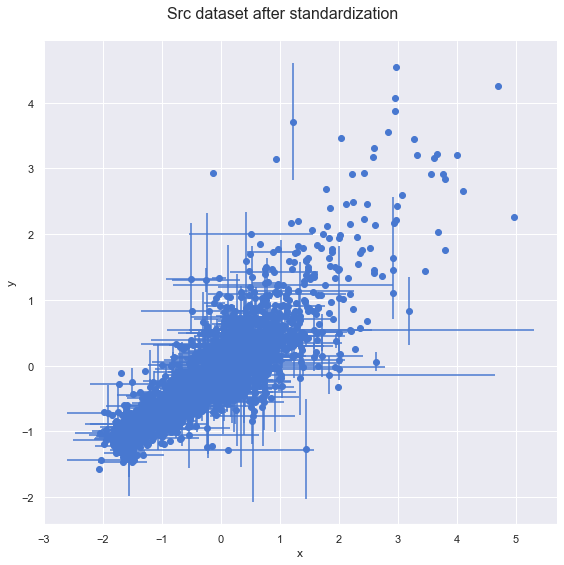

In [170]:
## scatterplot the standardized data
g = sns.FacetGrid(data, height=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
#_ = g.axes[0][0].set_ylim(ylims)
#_ = g.axes[0][0].set_xlim(xlims)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Src dataset after standardization', fontsize=16)

In [204]:
with pm.Model() as mdl_signoise:

    ## Define informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sigma=1, testval=pm.floatX(0.1))
    b1 = pm.Normal('b1_slope', mu=0.6, sigma=1, testval=pm.floatX(1.))

    ## Define linear model
    #yest_in = b0 + b1 * dfhoggs['x']
    yest_in = b0 + b1 * data['x']

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sigma=10, testval=pm.floatX(1.))
    sigma_y_out = pm.HalfNormal('sigma_y_out', sigma=5, testval=pm.floatX(1.))

    ## Define Bernoulli inlier / outlier flags according to a hyperprior
    ## fraction of outliers, itself constrained to [0, .5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=data.shape[0],
                              testval=np.random.rand(data.shape[0]) < 0.2)

    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = theano.shared(np.asarray(data['y'], dtype=theano.config.floatX))
    sigma_y_in = np.asarray(data['sigma_y'], dtype=theano.config.floatX)

    # Set up normal distributions that give us the logp for both distributions
    inliers = pm.Normal.dist(mu=yest_in, sigma=sigma_y_in).logp(yobs)
    outliers = pm.Normal.dist(mu=yest_out, sigma=sigma_y_in + sigma_y_out).logp(yobs)
    
    # Build custom likelihood, a potential will just be added to the logp and can thus function
    # like a likelihood that we would add with the observed kwarg.
    pm.Potential('obs', ((1 - is_outlier) * inliers).sum() + (is_outlier * outliers).sum())

In [213]:
with mdl_signoise:
    traces_signoise = pm.sample(tune=50000, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, yest_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 2 chains for 50_000 tune and 1_000 draw iterations (100_000 + 2_000 draws total) took 20040 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


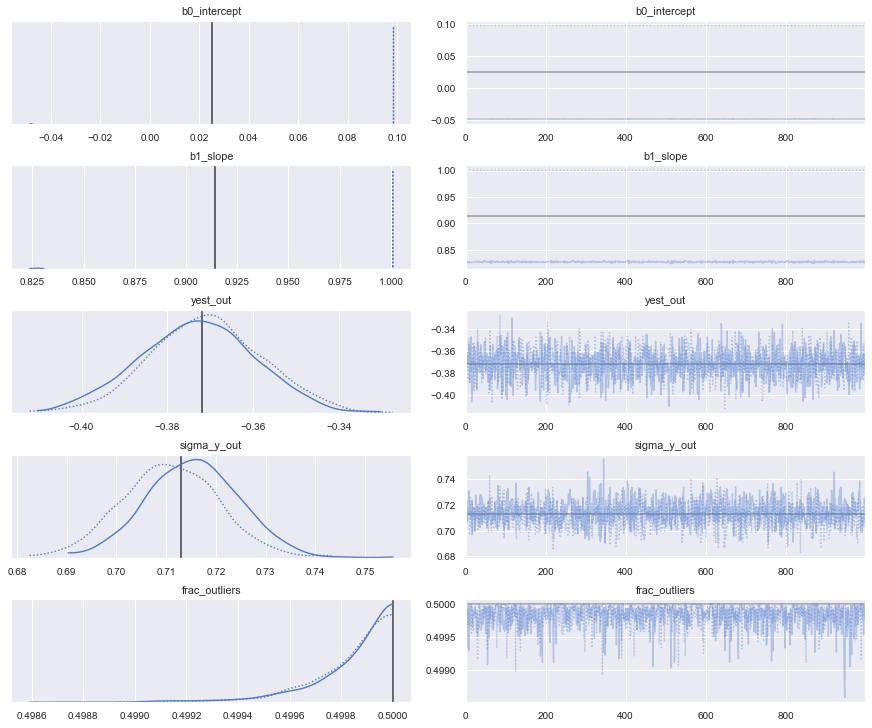

In [214]:
varnames = ['b0_intercept', 'b1_slope', 'yest_out', 'sigma_y_out', 'frac_outliers']
_ = pm.traceplot(traces_signoise, var_names=varnames,
                 lines=tuple([(k, {}, v['mean'])
                              for k, v in pm.summary(traces_signoise, varnames=varnames).iterrows()]))

In [215]:
data.reset_index(inplace=True)

ValueError: cannot insert level_0, already exists

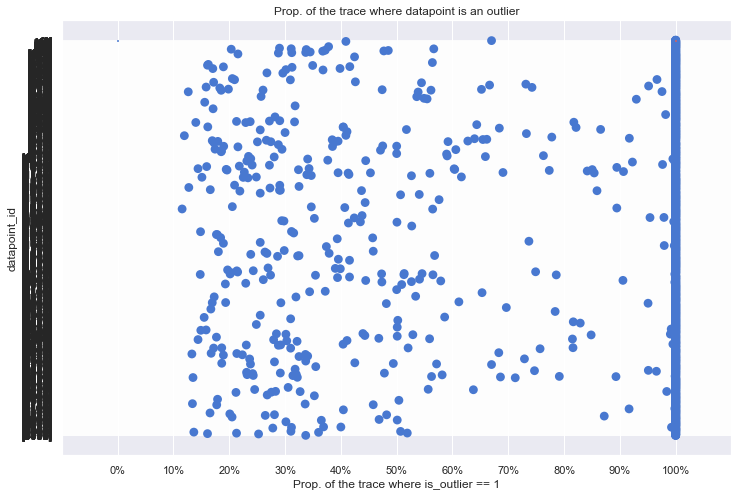

In [216]:
outlier_melt = pd.melt(pd.DataFrame(traces_signoise['is_outlier', -1000:],
                                   columns=['[{}]'.format(int(d)) for d in data.index]),
                      var_name='datapoint_id', value_name='is_outlier')
ax0 = sns.pointplot(y='datapoint_id', x='is_outlier', data=outlier_melt,
                   kind='point', join=False, ci=None, size=4, aspect=2)

_ = ax0.vlines([0,1], 0, 19, ['b','r'], '--')

_ = ax0.set_xlim((-0.1,1.1))
_ = ax0.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax0.set_xticklabels(['{:.0%}'.format(t) for t in np.arange(0,1.1,0.1)])

_ = ax0.yaxis.grid(True, linestyle='-', which='major', color='w', alpha=0.4)
_ = ax0.set_title('Prop. of the trace where datapoint is an outlier')
_ = ax0.set_xlabel('Prop. of the trace where is_outlier == 1')

In [217]:
cutoff = 5
data['outlier'] = np.percentile(traces_signoise['is_outlier'], cutoff, axis=0)
data['outlier'].value_counts()

1.0    3033
0.0     373
Name: outlier, dtype: int64

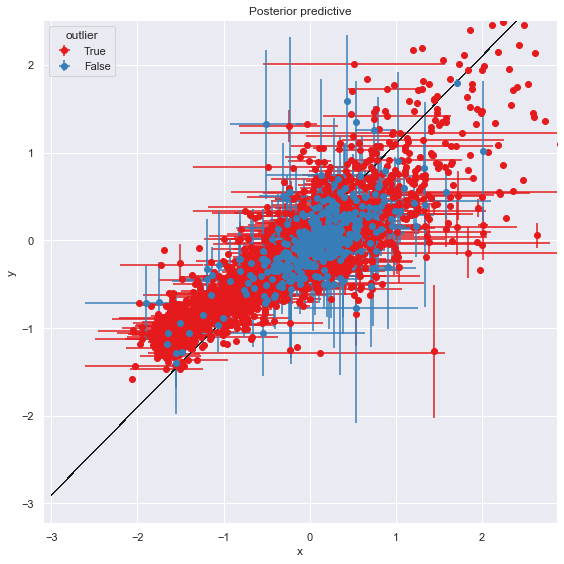

In [218]:
from matplotlib.lines import Line2D

g = sns.FacetGrid(data, height=8, hue='outlier', hue_order=[True, False],
                  palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0_intercept'] + samp['b1_slope'] * x

"""pm.plot_posterior_predictive_glm(traces_ols,
        eval=np.linspace(-3, 3, 10), lm=lm, samples=200, color='#22CC00', alpha=.2)

pm.plot_posterior_predictive_glm(traces_studentt, lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#FFA500', alpha=.5)"""

pm.plot_posterior_predictive_glm(traces_signoise, lm=lm,
        eval=np.linspace(-3, 3, 10), samples=2500, color='k', alpha=.3)

"""ols_line = Line2D([0], [0], color='#22CC00')
studentt_line = Line2D([0], [0], color='#FFA500')"""
hogg_line = Line2D([0], [0], color='#357EC7')
#line_legend = plt.legend([ols_line, studentt_line, hogg_line], ['OLS', 'Student-T', 'Hogg'], loc=4)
#plt.gca().add_artist(line_legend)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='').add_legend()
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

In [ ]:
idx = data['outlier']
plt.scatter(data[])